In [ ]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

  
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random 

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
w, h = 256,256
border = 5 

In [ ]:
ids = next(os.walk("/content/drive/MyDrive/dataset3/images/256/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  100


# **Data Reading and Train test split**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/dataset4/257/images/*.png"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/dataset4/257/labels/*.png"))

print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 300
Total Mask Image : 300


In [ ]:
X = np.zeros((len(train), h, w, 3), dtype=np.float32)
y = np.zeros((len(train_mask), h, w, 1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # print(n, img, mimg)
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w, 3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  X[n] = x_img/255.0
  y[n] = mask/255.0

0it [00:00, ?it/s]

In [ ]:
# Save the files in Numpy array for reusability
np.save('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/X.npy', X)
np.save('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/y.npy', y)
# print(X.shape, y.shape)
X = np.load('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/X.npy')
y = np.load('/content/drive/MyDrive/satellite-Image-Semantic-Segmentation-Unet-Tensorflow-keras/XandY/y.npy')
print(X.shape, y.shape)

(300, 256, 256, 3) (300, 256, 256, 1)


In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(270, 256, 256, 3) (270, 256, 256, 1) (30, 256, 256, 3) (30, 256, 256, 1)


188

# **Visualization the image and It masks**

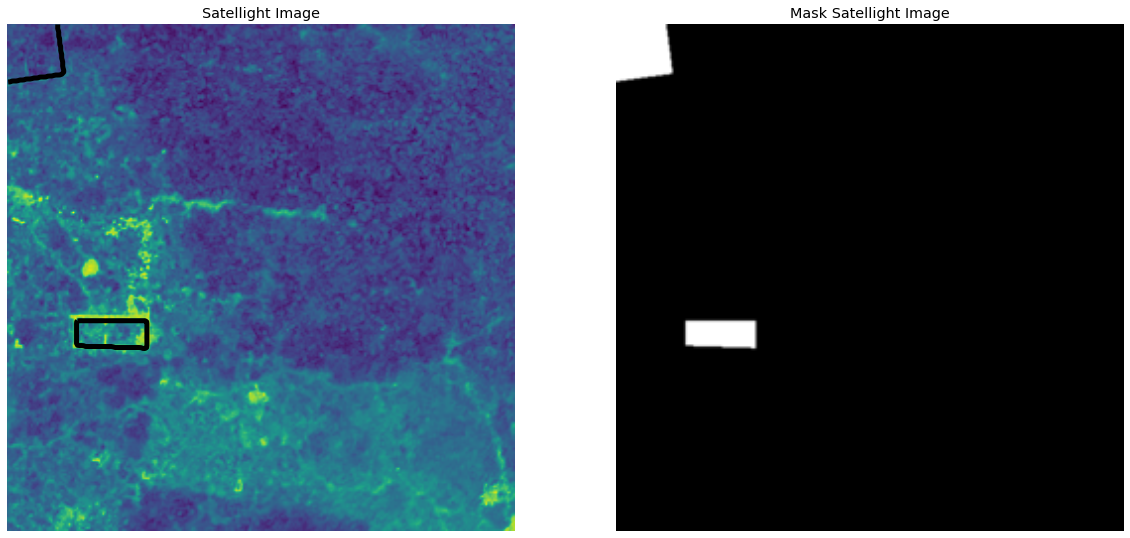

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
# valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
!pip install keras_unet_collection

     |████████████████████████████████| 67 kB 4.3 MB/s 


In [ ]:
from keras_unet_collection import models

In [ ]:
model = models.att_unet_2d((256,256, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                           backbone='VGG16', weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='attunet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 3), name='img')
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

0

In [ ]:
model.summary()

Model: "attunet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
VGG16_backbone (Functional)     [(None, 256, 256, 64 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
attunet_up0_decode_trans_conv ( (None, 32, 32, 512)  2359808     VGG16_backbone[0][4]             
__________________________________________________________________________________________________
attunet_up0_decode_bn (BatchNor (None, 32, 32, 512)  2048        attunet_up0_decode_trans_conv[0][
______________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ATTUnet-aug.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=12, epochs=50, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/50
23/23 [==============================] - 93s 2s/step - loss: 0.3925 - accuracy: 0.8217 - auc: 0.8549 - sensitivity_at_specificity: 0.9073 - specificity_at_sensitivity: 0.9575 - mean_io_u: 0.4414 - val_loss: 178.2929 - val_accuracy: 0.1549 - val_auc: 0.5026 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0058 - val_mean_io_u: 0.0902

Epoch 00001: val_loss improved from inf to 178.29291, saving model to model-ATTUnet-aug.h5
Epoch 2/50
23/23 [==============================] - 30s 1s/step - loss: 0.1908 - accuracy: 0.9152 - auc: 0.9448 - sensitivity_at_specificity: 0.9636 - specificity_at_sensitivity: 0.9968 - mean_io_u: 0.4544 - val_loss: 8.4848 - val_accuracy: 0.7834 - val_auc: 0.9021 - val_sensitivity_at_specificity: 0.9751 - val_specificity_at_sensitivity: 0.8625 - val_mean_io_u: 0.7069

Epoch 00002: val_loss improved from 178.29291 to 8.48484, saving model to model-ATTUnet-aug.h5
Epoch 3/50
23/23 [==============================] - 32s 1s/ste

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,mean_io_u,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,val_mean_io_u,lr
25,0.025259,0.963717,0.998721,0.998625,1.000000,0.440659,0.081475,0.950096,0.985277,0.979357,0.998564,0.424239,0.00010
26,0.024195,0.963956,0.998661,0.998399,1.000000,0.439189,0.081986,0.950015,0.985014,0.978670,0.998608,0.423442,0.00010
27,0.023439,0.964112,0.998648,0.998321,1.000000,0.439968,0.082316,0.950199,0.984785,0.978271,0.998504,0.423548,0.00010
28,0.023228,0.964142,0.998686,0.998362,1.000000,0.438115,0.082713,0.950215,0.984845,0.978492,0.998366,0.424038,0.00010
29,0.022952,0.964185,0.998761,0.998500,1.000000,0.436785,0.083431,0.950207,0.984108,0.976728,0.998481,0.423689,0.00010
19,0.033387,0.961962,0.998084,0.998743,0.999998,0.437441,0.083919,0.948397,0.989162,0.990389,0.998188,0.432050,0.00100
30,0.022789,0.964218,0.998791,0.998502,1.000000,0.437704,0.084293,0.950138,0.983807,0.976331,0.998243,0.423769,0.00010
20,0.031117,0.962514,0.998185,0.998516,0.999997,0.438581,0.084461,0.947979,0.987934,0.987706,0.999095,0.425368,0.00100
31,0.022605,0.964245,0.998755,0.998430,1.000000,0.437890,0.084614,0.950148,0.983848,0.976586,0.998082,0.424738,0.00001
32,0.022408,0.964272,0.998847,0.998567,1.000000,0.437111,0.084785,0.950190,0.983926,0.976829,0.997978,0.425722,0.00001


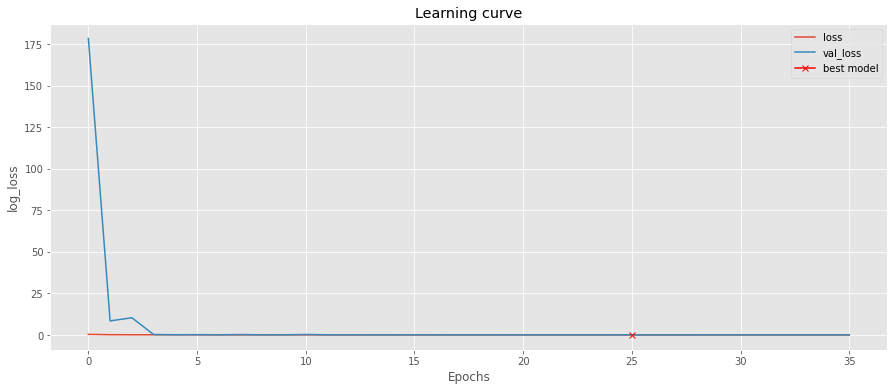

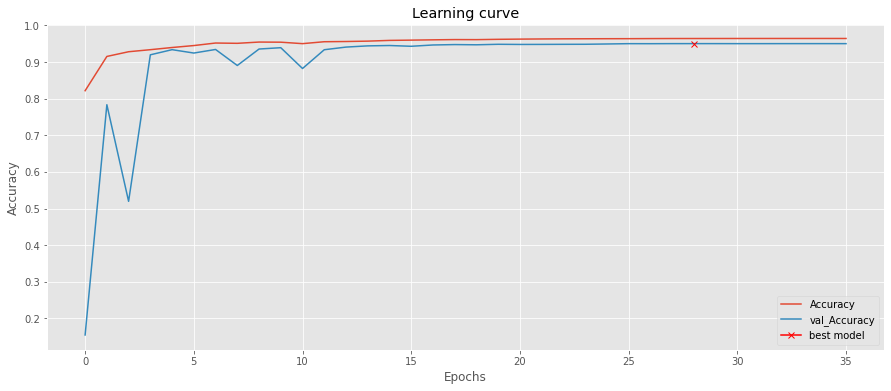

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [ ]:
model.load_weights('model-ATTUnet-aug.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 25s 25s/step - loss: 0.0815 - accuracy: 0.9501 - auc: 0.9853 - sensitivity_at_specificity: 0.9794 - specificity_at_sensitivity: 0.9986 - mean_io_u: 0.4242


[0.0814749076962471,
 0.9500961303710938,
 0.9852771162986755,
 0.979357123374939,
 0.998563826084137,
 0.4242388606071472]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 35ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
from keras.metrics import MeanIoU
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(y_train,preds_train_t)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9416423


In [ ]:
from keras.metrics import MeanIoU
num_classes = 2
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(y_test,preds_val_t)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.901145


In [ ]:
model.compile(optimizer='adam', loss='Binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Confusion matrix
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), preds_val_t.argmax(axis=1))

AttributeError: ignored

In [ ]:
from keras_unet_collection import losses

In [ ]:
print('Testing set IoU loss = {}'.format(np.mean(losses.iou_seg(y_train,preds_train_t))))

Testing set IoU loss = 0.057940006256103516


In [ ]:
from keras import backend as K

In [ ]:
def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
y_train_1=tf.image.convert_image_dtype(y_train, dtype=tf.float32, saturate=False)
preds_train_t_1= tf.image.convert_image_dtype(y_train, dtype=tf.float32, saturate=False)

In [ ]:
DICE=dice_coef(y_train_1,preds_train_t_1)
DICE

<tf.Tensor: shape=(), dtype=float32, numpy=0.9791743>

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()    

# **Predictions on training set**

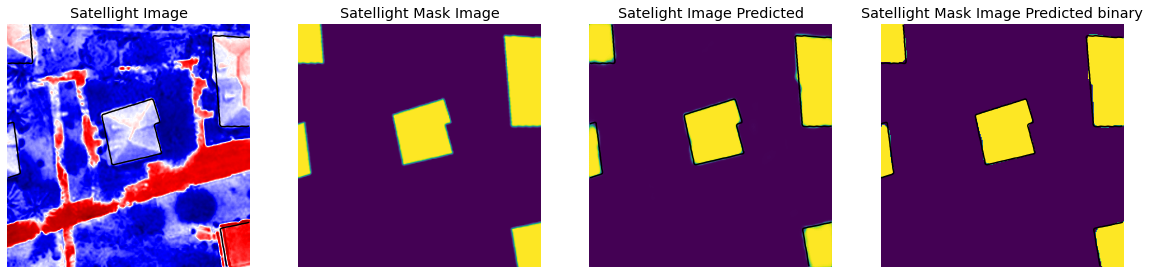

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t,30)

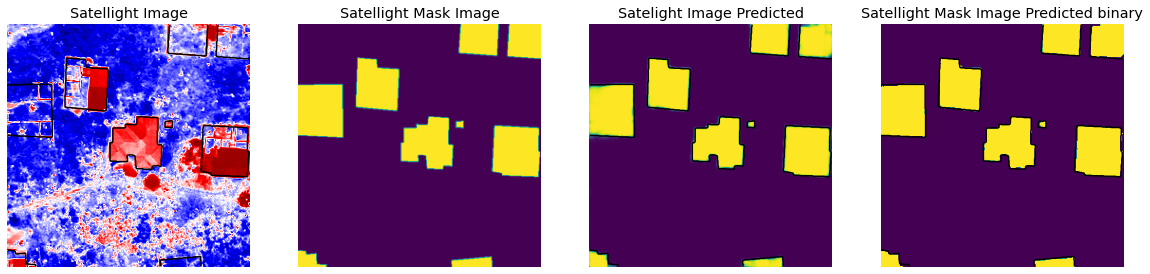

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t,31)

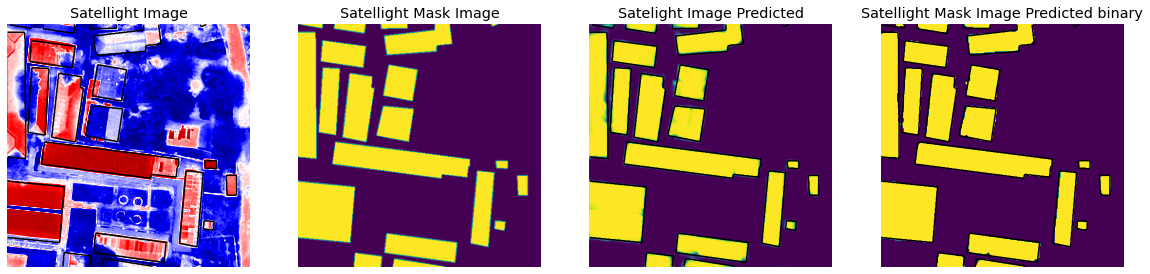

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,1)

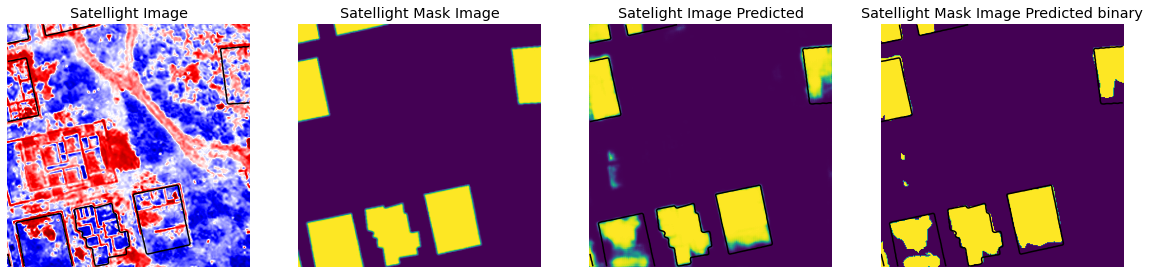

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,0)

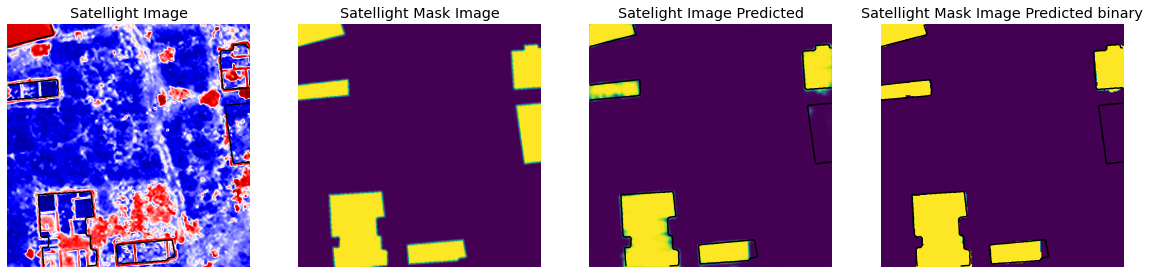

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,2)

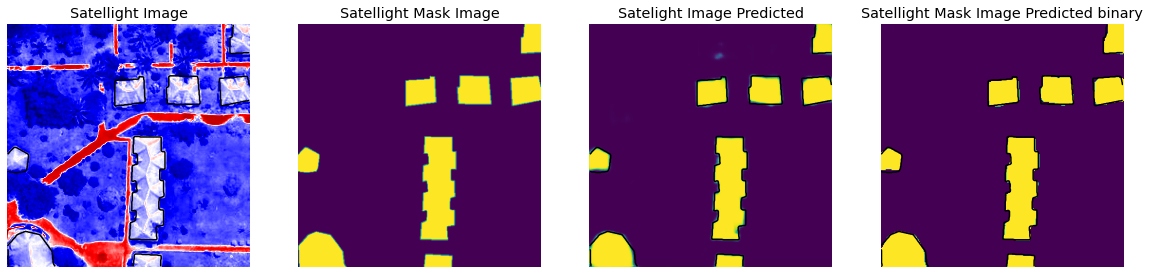

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,3)

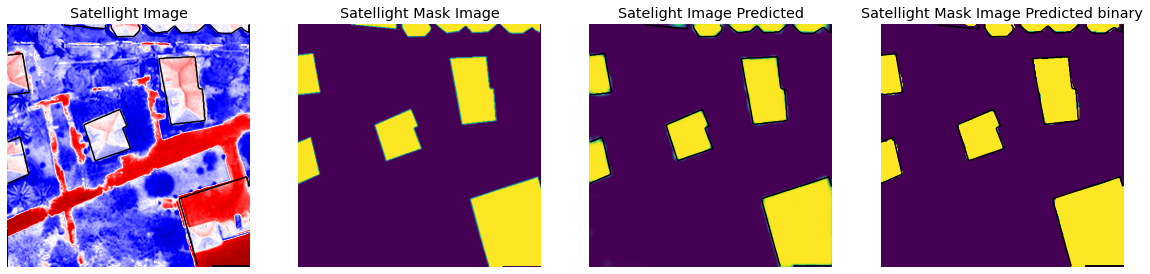

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,4)

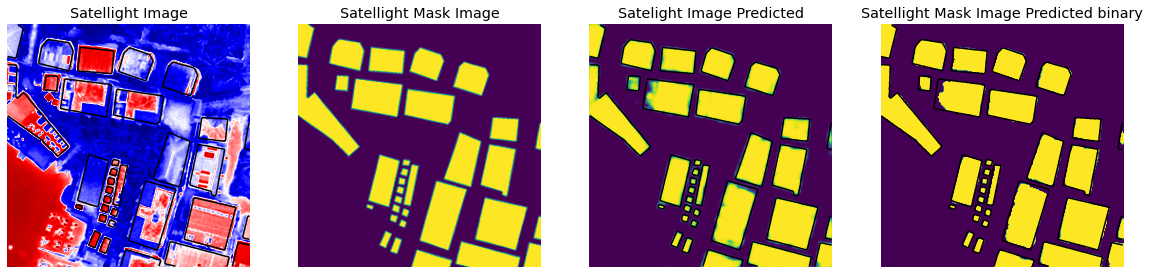

In [ ]:
plot_sample(X_test, y_test, preds_val, preds_val_t,15)